## Overview

My goal is to accurately assign Standard Occupational Classification (SOC) codes to job ads. Unfortunately, there is no source of job ads that already have trustworthy SOC codes that could be used to fit a model.

The U.S. Bureau of Labor Statistics (BLS) documentation includes a terse definition for each occupation, and a set of "direct match titles." The direct match titles are job titles that unambiguously relate to a single occupation. Many jobs do not have a direct match between title and occupation, so this can't be used tag all job ads. (If it could, this probject would be much less useful.) However, this *can* be used to label *some* job ads, and I can use that.

I use the O\*NET occupation definitions and task descriptions to augment the BLS occupations with more text to inform modeling and more fine-grained occupations.

Job ads that can be labeled by direct match titles form a modeling subset. I use that subset to select a text embedding (vectorization) of job ads that is effective at reproducing the same labels in a 1-nearest-neighbor (1-NN) model. The 1-NN model uses only the occupation definitions as its reference data, not the labeled job ads. Mathematically, the result of this should be an embedding of job descriptions in a metric space that approximates the SOC system.

In [1]:
import functools as fn
import itertools as itr
import re
import warnings
from collections import Counter

import gensim.sklearn_api as gsk
import matplotlib.pyplot as plt
import metric_learn as metl
import numpy as np
import numpy.linalg as la
import pandas as pd
import seaborn as sns
import sklearn.decomposition as dc
import sklearn.feature_extraction.text as fet
import sklearn.linear_model as lm
import sklearn.metrics as met
import sklearn.metrics.pairwise as dist
import sklearn.model_selection as ms
import sklearn.preprocessing as pp
import spacy
from sklearn.neighbors import KNeighborsClassifier

warnings.filterwarnings('ignore')

/Users/jeremy/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# load data
jobs = pd.read_feather('../processed_data/job_ads.feather')
jobs['soc_detail'] = [pd.NA if soc == '' else soc for soc in jobs['soc_detail']]

occupations = pd.read_feather('../processed_data/occupations.feather')

In [3]:
occupations.sample(10)

,soc_onet,soc_major,soc_minor,soc_broad,soc_detail,title,definition,def_lemma
483,29-2036.00,29-0000,29-2000,29-2030,29-2036,Medical Dosimetrists,"Generate radiation treatment plans, develop ra...",generate radiation treatment plan develop radi...
671,43-5021.00,43-0000,43-5000,43-5020,43-5021,Couriers and Messengers,"Pick up and deliver messages, documents, packa...",pick deliver message document package item off...
728,47-2121.00,47-0000,47-2000,47-2120,47-2121,Glaziers,"Install glass in windows, skylights, store fro...",install glass window skylight store front disp...
976,53-6051.01,53-0000,53-6000,53-6050,53-6051,Aviation Inspectors,"Inspect aircraft, maintenance procedures, air ...",inspect aircraft maintenance procedure air nav...
734,47-2152.00,47-0000,47-2000,47-2150,47-2152,"Plumbers, Pipefitters, and Steamfitters","Assemble, install, alter, and repair pipelines...",assemble install alter repair pipeline pipe sy...
42,11-9121.01,11-0000,11-9000,11-9120,11-9121,Clinical Research Coordinators,"Plan, direct, or coordinate clinical research ...",plan direct coordinate clinical research proje...
870,51-5112.00,51-0000,51-5100,51-5110,51-5112,Printing Press Operators,"Set up and operate digital, letterpress, litho...",set operate digital letterpress lithographic f...
390,27-2042.00,27-0000,27-2000,27-2040,27-2042,Musicians and Singers,Play one or more musical instruments or sing. ...,play musical instrument sing perform stage bro...
986,53-7062.00,53-0000,53-7000,53-7060,53-7062,"Laborers and Freight, Stock, and Material Move...","Manually move freight, stock, luggage, or othe...",manually freight stock luggage material perfor...
692,43-9081.00,43-0000,43-9000,43-9080,43-9081,Proofreaders and Copy Markers,Read transcript or proof type setup to detect ...,read transcript proof type setup detect mark c...


In [4]:
jobs.sample(10)

,title,description,desc_lemma,soc_detail
6133,regional director - general commercial sales west,Job Description\nThe Regional Director of Gene...,job description \n regional director general c...,<NA>
22371,"macy's countryside, clearwater, fl: sales supe...","Job Overview:\nAs a Sales Supervisor, you will...",job overview \n sales supervisor support macy ...,<NA>
27209,operations supervisor,Purpose of Role\nThe Operations Coach is accou...,purpose role \n operations coach accountable s...,<NA>
14221,enterprise account development representative,Our mission at Suplari is to shine the light o...,mission suplari shine light intelligence compa...,<NA>
20714,associate product manager (purchasing),Job Req ID: 5805\nAbout Supermicro:\nSupermicr...,job req id 5805 \n supermicro \n supermicro ® ...,<NA>
8623,senior solutions architect,Minimum of 10 years enterprise IT application ...,minimum 10 year enterprise application experie...,<NA>
22825,general manager,Job Description\nA General Manager must be com...,job description \n general manager commit insp...,11-1021
16178,rental services territory manager,Department: Rents Sales - Bensalem\nResponsibi...,department rents sales bensalem \n responsibil...,<NA>
2276,bilingual leasing agent,Well-established property has an immediate ope...,establish property immediate open leasing cons...,<NA>
23201,.net developer,Autodata Solutions is looking for a .NET Devel...,autodata solutions look .net developer join gr...,<NA>


I already labeled many jobs with an SOC code (detail level) by matching the title in the job ad with a list of "direct match titles" from the BLS that unambiguously fall within a single occupation. (See data_wrangling.ipynb.)

In [5]:
dm_jobs = jobs[jobs['soc_detail'].notna()]  # direct matched jobs
n_dm = len(dm_jobs)
n_jobs = len(jobs)
print(f'{n_dm} jobs out of {n_jobs} ({n_dm / n_jobs:.0%}) could be directly matched by title.')

n_dmsoc = dm_jobs['soc_detail'].nunique()
n_soc = occupations['soc_detail'].nunique()
print(f'{n_dmsoc} occupations out of {n_soc} ({n_dmsoc / n_soc:.0%}) are represented in the directly matched jobs.')

3163 jobs out of 30002 (11%) could be directly matched by title.
167 occupations out of 848 (20%) are represented in the directly matched jobs.


### Text Embedding Selection

In [6]:
# only use unlabeled jobs for embedding corpus so that labeled jobs are test set
nl_jobs = jobs[jobs['soc_detail'].isna()]
raw_corpus = [*nl_jobs['description'], *occupations['definition']]
lemma_corpus = [*nl_jobs['desc_lemma'], *occupations['def_lemma']]
corpus_source = [*np.zeros(len(nl_jobs)), *np.ones(len(occupations))]

X_test = dm_jobs['desc_lemma']
y_test = dm_jobs['soc_detail']

# separate official reference definitions of detail-level occupations
# as opposed to O*NET's *.NN specializations
bls_occupations = occupations[occupations['soc_onet'].str.endswith('.00')]
y_bls = bls_occupations['soc_detail']

# separate matched from not-matched occupations for model diagnosis
dm_soc = occupations[occupations['soc_detail'].isin(dm_jobs['soc_detail'].unique())]
nl_soc = occupations[~occupations['soc_detail'].isin(dm_jobs['soc_detail'].unique())]

In [7]:
# 1-NN model with occupation definitions
def OneNN(x_transform_func, y_transform_func=None, metric='cosine', use_lemmas=True):
    if use_lemmas:
        X = occupations['def_lemma']
    else:
        X = occupations['definition']
    
    if y_transform_func is None:
        y = occupations['soc_detail']
    else:
        y = y_transform_func(occupations['soc_detail'])
        
    model = KNeighborsClassifier(n_neighbors=1, metric=metric, n_jobs=-1)
    return model.fit(x_transform_func(X), y)

In [8]:
# embedding evaluation functions
emb_names = []
emb_scores = []
emb_types = []

def emb_score(x_transform_func, X_test, y_test, metric='cosine', use_lemmas=True):
    """Scores the performance of an embedding for 1-NN classification of occupations"""
    model = OneNN(x_transform_func, metric=metric)
    y_pred = model.predict(x_transform_func(X_test))
    score = met.accuracy_score(y_test, y_pred)

    return model, score, y_pred


def save_emb_score(name, score, emb_type):
    emb_names.append(name)
    emb_scores.append(score)
    emb_types.append(emb_type)
    return None


def emb_score_dataframe():
    return pd.DataFrame({
        'name': emb_names,
        'accuracy': emb_scores,
        'type': emb_types
    })


def soc_residuals_dataframe(y_pred):
    """DataFrame of SOC classification errors for troubleshooting"""
    mismatches = dm_jobs['soc_detail'] != y_pred
    return pd.DataFrame({
        'job_soc': dm_jobs[mismatches]['soc_detail'],
        'job_title': dm_jobs[mismatches]['title'],
        'nn_soc': y_pred[mismatches],
        'nn_title': [title_from_soc(soc) for soc in y_pred[mismatches]]
    })


def tfidf_dataframe(tfidf_model, X):
    """DataFrame of TF-IDF representations of X"""
    y = tfidf_model.transform(X)
    columns = tfidf_model.get_feature_names()
    return pd.DataFrame(y.todense(), columns=columns)


def title_from_soc(soc):
    if len(soc) == 7:
        soc += '.00'
    return occupations[occupations['soc_onet'] == soc]['title'].values[0]

In [9]:
# embedding 1: basic TF-IDF
max_features = y_bls.nunique() * 2
tfidf_vec = fet.TfidfVectorizer(max_df=0.5, max_features=max_features)
tfidf_vec.fit(lemma_corpus)

_, score, y_pred = emb_score(tfidf_vec.transform, X_test, y_test)
print(score)
save_emb_score('TF-IDF', score, 'Vectorization')

0.1874802402782169


That doesn't look great. Why?

In [10]:
soc_residuals_dataframe(y_pred).sample(20)

,job_soc,job_title,nn_soc,nn_title
5909,13-2011,senior accountant,11-9021,Construction Managers
8658,11-2022,federal software sales account manager - air f...,11-3111,Compensation and Benefits Managers
2405,23-2011,legal assistant ii,43-4031,"Court, Municipal, and License Clerks"
17581,11-9041,product success engineering manager,13-1199,"Business Operations Specialists, All Other"
4102,11-2022,"regional sales manager, enterprise (philadelph...",13-1011,"Agents and Business Managers of Artists, Perfo..."
23310,11-1021,general manager,41-2022,Parts Salespersons
16316,15-1254,salesforce web developer,41-9021,Real Estate Brokers
24797,11-2022,regional sales manager,19-2021,Atmospheric and Space Scientists
17673,11-1021,general manager,11-9051,Food Service Managers
25171,11-2022,area sales director,47-4061,Rail-Track Laying and Maintenance Equipment Op...


The good news is that most of the mis-labels appear to have a certain reasonable logic to them. These aren't bulls-eyes, but these aren't missing the target, either. Unfortunately, I do not have benchmark distances or similarities between occupations to quantify how close these labels are to what they should be. (O\*NET does publish a [Career Changers Matrix](https://www.onetcenter.org/dictionary/25.0/excel/career_changers_matrix.html) and a [Career Starters Matrix](https://www.onetcenter.org/dictionary/25.0/excel/career_starters_matrix.html) relating careers that might be relatively easy to transition between. I considered using these to construct benchmark inter-occupation distances via graph paths; but these matrices are constructed from the same source data as the occupation O\*NET task descriptions I'm using to construct occupation embeddings, not from actual occupation transition histories. Using those matrices to benchmark occupation distances would be circular reasoning.)

#### Better Embedding Needed

Some types of mismatches suggest that the embedding fails to capture significant nuances of job ads, and that the embedding has room for improvement.

- Completely different disciplines with some vaguely similar functions:
    - Software Developers (15-1252) vs. Mechanical Engineers (17-2141).
    - Gemologist/Appraiser (51-9071.06) vs. Graders and Sorters, Agricultural Products (45-2041)

- Occupations in the same domain with different goals:
    - Staff Accountant (13-2011) vs. Tax Examiners and Collectors, and Revenue Agents (13-2081).
    - Marketing & Public Relations Manager/Analyst (11-2032) vs. Advertising and Promotions Managers (11-2011)

- Jobs with a target audience confused with the target audience:
    - Sales Manager (of medical diagnostics) (11-2022) vs. Physicians, All Other (11-9199).

- Jobs matched with a less precisely-defined occupation: General Manager (11-1021) vs. Managers, All Other (11-9199)

- Managers confused with their direct reports (whose tasks they may sometimes perform):
    - Marketing Director (11-2021) vs. Market Research Analysts and Marketing Specialists (13-1161).
    - Clinic Director (11-9111) vs. Licensed Practical and Licensed Vocational Nurses (29-2061).
    - Assistant Store Manager Trainee (41-1011) vs. Stockers and Order Fillers (53-7065)
    - Hospitality Operations Manager (11-1021) vs. Hotel, Motel, and Resort Desk Clerks (43-4081)

#### Better Occupation Scheme Needed

Some types of mismatches show how the SOC system fails to capture the full reality of the labor market. The existence of these mismatches means we cannot rely on classification accuracy alone to evaluate the quality of the job ad classifications. Modeling may detect information that is overlooked or discarded in the SOC system, and we should give models credit for that somehow.

Some mismatches appear to be specialists in one occupation whose work routinely includes tasks from other occupations. These are arguably inevitable whenever making hard partitions among phenomena evenly distributed on a continuum.

- Front-End Software Engineer (Software Developers, 15-1252) vs. Web and Digital Interface Designers (15-1255).
- Commercial Attourney (23-1011) vs. Labor Relations Specialists (13-1075).
- Mortgage Loan Officer (13-2072) vs. Loan Interviewers and Clerks (43-4131)

Some mismatches appear to be a disagreement between the labor market and the BLS about what titles match what occupations, especially within specific industries—the BLS included titles in the direct match title file that it should not have. These mismatches tend to coincide with other confusions between related occupations.

- What should be a Food Service Manager (11-9051) according to the BLS is advertised as a "General Manager" (11-1021), but is nearest-neighbor matched with the work of direct reports such as Cooks, Fast Food (35-2011).
- A job is advertised as a "Business Analyst", which direct-title-matches Management Analysts (13-1111); but that title means something different in the context of software development (Computer Systems Analysts, 15-1211), and often includes tasks from related occupations such as Software Quality Assurance Analysts and Testers (15-1253).

In [11]:
# embedding 2: TF-IDF -> LSA
lsa = dc.TruncatedSVD(n_components=200)
lsa.fit(tfidf_vec.transform(lemma_corpus))


def tfidf_lsa(x):
    return lsa.transform(tfidf_vec.transform(x))


_, score, _ = emb_score(tfidf_lsa, X_test, y_test)
print(score)
save_emb_score('LSA', score, 'Dimension Reduction')

0.20644957319000948


In [12]:
soc_residuals_dataframe(y_pred).sample(20)

,job_soc,job_title,nn_soc,nn_title
27611,11-1021,assistant general manager,43-4081,"Hotel, Motel, and Resort Desk Clerks"
17064,13-1111,it project manager / business analyst,15-1299,"Computer Occupations, All Other"
16530,13-1161,"senior marketing specialist, energy efficiency",17-2199,"Engineers, All Other"
27746,21-1012,admissions counselor - adult degree completion...,25-3041,Tutors
16671,15-1252,sr. software engineer - sap basis administrator,15-1299,"Computer Occupations, All Other"
22695,11-2022,sales director - advertising/media solutions t...,41-3011,Advertising Sales Agents
8932,41-1011,retail assistant store manager,41-2031,Retail Salespersons
7810,43-6011,executive assistant,13-1082,Project Management Specialists
18930,39-5094,esthetician/wax specialist-skokie,43-4111,"Interviewers, Except Eligibility and Loan"
2942,27-3043,copywriter & content creator (bw leadership in...,43-9081,Proofreaders and Copy Markers


Using latent semantic analysis to reduce the dimensionality of the TF-IDF embedding slightly improves accuracy, and it appears to make the same types of errors.

In [13]:
# embedding 3: 2-gram TF-IDF
tfidf2_vec = fet.TfidfVectorizer(
    max_df=0.2, max_features=max_features, ngram_range=(2, 2))
tfidf2_vec.fit(lemma_corpus)

_, score, _ = emb_score(tfidf2_vec.transform, X_test, y_test)
print(score)
save_emb_score('TF-IDF (2-grams)', score, 'Vectorization')

0.04773948782801138


I hoped that extending the TF-IDF representation to include 2-grams would help capture some of the nuances being missed by 1-grams, but apparently this actually performs worse.

In [14]:
# spacy language model (GloVe), see https://spacy.io/models/en
nlp_md = spacy.load('en_core_web_md', disable=['tagger', 'parser', 'ner'])


def glove_avg_vectors(doc_iter):
    return np.array([nlp_md(d).vector for d in doc_iter])

In [15]:
# embedding 4: GloVe average
_, score, _ = emb_score(glove_avg_vectors, X_test, y_test)
print(score)
save_emb_score('GloVe', score, 'Vectorization')

0.10275055327220993


In [16]:
# GloVe with TF-IDF-weighted average transform
def glove_tfidf_vector(text, weights, vocab=tfidf_vec.vocabulary_):
    """document vector as weighted mean of token vectors"""
    mean_weight = np.mean(weights)
    doc = nlp_md(text)
    vec = None
    total_weight = 0
    for i, token in enumerate(doc):
        try:
            weight = weights[vocab[token.text]]
        except:
            weight = mean_weight

        total_weight += weight
        if vec is None:
            vec = token.vector * weight
        else:
            vec += (token.vector - vec) * weight / total_weight
    return vec


def glove_tfidf_vectors(text_iter):
    """document vectors as a TF-IDF-weighted mean of token vectors"""
    docs_tfidf = tfidf_vec.transform(text_iter)
    return [glove_tfidf_vector(t, w.toarray()[0]) for t, w in zip(text_iter, docs_tfidf)]

In [17]:
# embedding 5: GloVe TF-IDF-weighted average
_, score, _ = emb_score(glove_tfidf_vectors, X_test, y_test)
print(score)
save_emb_score('GloVe * TF-IDF', score, 'Vectorization')

0.1451153967752134


In [18]:
# functions for smooth inverse frequency (SIF) and common component removal embedding
# see: https://openreview.net/forum?id=SyK00v5xx, https://github.com/PrincetonML/SIF


def tokens(text):
    """list of tokens in text"""
    return [t.text.lower() for t in nlp_md(text) if not t.is_punct]


def token_matrix(texts):
    """list of lists of tokens in text (for gensim input)"""
    return [tokens(t) for t in texts]


def word_counts(texts):
    """counter of words (tokens) in texts"""
    wc = Counter()
    for t in texts:
        wc.update(tokens(t))

    return wc


def _sif_pca(X, n_components=1):
    """first principle components of X"""
    svd = dc.TruncatedSVD(n_components=n_components).fit(X)
    return svd.components_


def _sif_word_weight_func(texts, a=1e-3):
    # a: smoothing parameter
    weights = dict(word_counts(texts))
    n = sum(weights.values())
    smooth_weights = {k: a / (a + (v + 1) / (n + 2))
                      for k, v in weights.items()}

    def weight(word):
        try:
            return smooth_weights[word]
        except:
            return a / (a + 1 / (n + 2))

    return weight


def _sif_word_mean(vector_func, word_weight_func, text):
    t = tokens(text)
    weights = [word_weight_func(s) for s in t]
    return np.average(vector_func(t), axis=0, weights=weights)


def _sif_remove_common_component(X, pc):
    """Remove projection of X on common component vector"""
    if pc.shape[0] == 1:
        return (X - X.dot(pc.T) * pc)[0]
    else:
        return X - X.dot(pc.T).dot(pc)


def sif_transform_func(texts, vector_func, a=1e-3, n_components=1):
    """Returns function to transform a document into a feature vector"""
    # a: smoothing parameter
    word_weight = _sif_word_weight_func(texts, a=1e-3)
    _word_mean = fn.partial(_sif_word_mean, vector_func, word_weight)

    if n_components == 0:
        transform = _word_mean

    else:
        unadjusted_docs = [_word_mean(t) for t in texts]
        common_component = _sif_pca(unadjusted_docs, n_components)

        def transform(x):
            return _sif_remove_common_component(_word_mean(x), common_component)

    return lambda x: np.array([transform(y) for y in x])

In [19]:
# embedding 6: SIF
sif = sif_transform_func(lemma_corpus, glove_avg_vectors)

_, score, _ = emb_score(sif, X_test, y_test)
print(score)
save_emb_score('SIF', score, 'Vectorization')

0.1574454631678786


In [20]:
# embedding 7: Doc2Vec
# parameters based on https://arxiv.org/abs/1607.05368v1
d2v = gsk.D2VTransformer(size=300, window=15, min_count=5, sample=1e-5, negative=5,
                         dm=0, dbow_words=1, alpha=0.025, min_alpha=1e-4, iter=100, workers=8)
d2v.fit(token_matrix(lemma_corpus))  # gensim wants input with tokens separated

_, score, _ = emb_score(lambda x: d2v.transform(token_matrix(x)), X_test, y_test)
print(score)
save_emb_score('Doc2Vec', score, 'Vectorization')

0.0869427758457161


Different embedding methods don't seem to be improving much. Plotting the embedded data might help diagnose the limitation(s).

In [21]:
# plot functions
def hide_ticks(axis):
    """Hides tick marks on a matplotlib axis, and makes axes use equal units"""
    axis.axes.xaxis.set_visible(False)
    axis.axes.yaxis.set_visible(False)
    return None


def hide_ticks_square(axis):
    """Hides tick marks on a matplotlib axis, and makes axes use equal units"""
    hide_ticks(axis)
    square_axes(axis)
    return None


def square_axes(axis):
    """Sets plot axis dimensions to equal units"""
    axis.set_aspect('equal', adjustable='datalim')
    return None


def emb_plot_data(x_transform_func, split_soc_defs=False, split_job_ads=False):
    n_matched = len(occupations)
    n_unmatched = n_matched
    if split_job_ads:
        X_jobs = [*nl_jobs['desc_lemma'].sample(n_unmatched),
                  *dm_jobs['desc_lemma'].sample(n_matched)]
        label_jobs = [*(['Ad (Unmatched)'] * n_unmatched),
                      *(['Ad (Matched)'] * n_matched)]
        order_jobs = ['Ad (Unmatched)', 'Ad (Matched)']
    else:
        n = n_unmatched + n_matched
        X_jobs = jobs['desc_lemma'].sample(n)
        label_jobs = ['Ad'] * n
        order_jobs = ['Ad']

    if split_soc_defs:
        n_unmatched = len(nl_soc)
        n_matched = len(dm_soc)
        X_soc = [*nl_soc['def_lemma'],
                 *dm_soc['def_lemma']]
        label_soc = [*(['Definition (Not Matched)'] * n_unmatched),
                     *(['Definition (Matched)'] * n_matched)]
        order_soc = ['Definition (Not Matched)',
                     'Definition (Matched)']
    else:
        n = len(occupations)
        X_soc = occupations['def_lemma'].sample(n)
        label_soc = ['Definition'] * n
        order_soc = ['Definition']

    X = [*X_jobs, *X_soc]
    labels = [*label_jobs, *label_soc]
    order = [*order_jobs, *order_soc]
    return x_transform_func(X), labels, order


split_plot_data = fn.partial(
    emb_plot_data, split_soc_defs=True, split_job_ads=True)


def emb_plot(X, labels, label_order, title=None):
    fig, ax = plt.subplots(1, 1, figsize=(16, 9))
    emb_subplot(X, labels, label_order)(ax)
    if title is not None:
        plt.suptitle(title)
    plt.show()
    return None


def emb_subplot(X, labels, label_order, title=None):
    X_plot = dc.PCA(n_components=2).fit_transform(X)

    def plot(ax):
        sns.scatterplot(*X_plot.T, hue=labels, hue_order=label_order,
                        alpha=0.2, palette='tab10', ax=ax)
        if title is not None:
            ax.set_title(title)
        hide_ticks_square(ax)
        return None

    return plot


def plot_pair(a_plot_func, b_plot_func, title=None):
    fig, ax = plt.subplots(1, 2, figsize=(16, 9))

    a_plot_func(ax[0])
    b_plot_func(ax[1])

    if title is not None:
        plt.suptitle(title)
    plt.show()
    return None

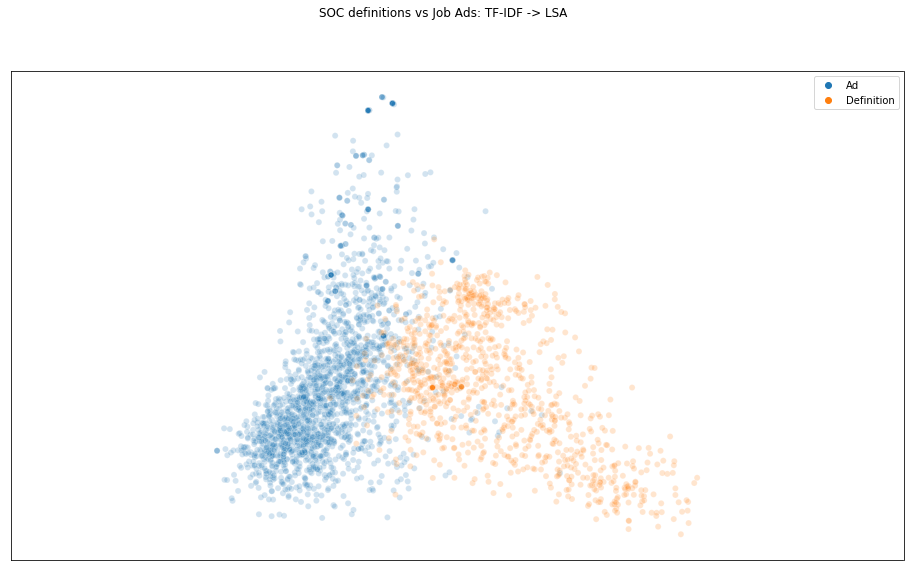

In [22]:
# visualize best embedding so far
emb_plot(*emb_plot_data(tfidf_lsa), 'SOC definitions vs Job Ads: TF-IDF -> LSA')

A good embedding for this problem should disperse SOC definitions and job ads roughly evenly in the same regions. This is not what's happening. The SOC definitions are closer to each other than they are to the jobs we want them to represent. This is likely due to shared idiosyncratic language in each of the different data sources.

The SIF embedding method uses common component removal to reduce the effect of syntax so the embedding can focus on "bigger picture" meaning. This is analgous to why we might remove stopwords from a corpus or down-weight frequent words in various average-of-word-vectors embeddings. Perhaps being more aggressive with common component removal might extend this effect to the stylistic difference between BLS definitions and job ads.

In [23]:
# embedding 8: SIF-N, remove more common components
n_components = []
scores = []

for i in range(10):
    sif_test = sif_transform_func(
        lemma_corpus, glove_avg_vectors, n_components=i)

    _, score, _ = emb_score(sif_test, X_test, y_test)

    n_components.append(i)
    scores.append(score)

sif_df = pd.DataFrame({
    'n_components': n_components,
    'score': scores
})

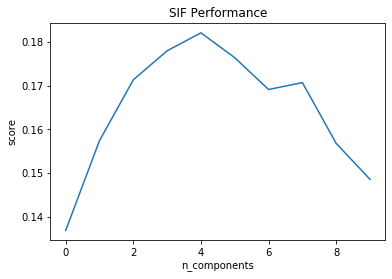

In [24]:
sns.lineplot(x='n_components', y='score', data=sif_df, ci=None)
plt.title('SIF Performance')
plt.show()

In [25]:
# SIF-4
sif4 = sif_transform_func(lemma_corpus, glove_avg_vectors, n_components=4)

_, score, _ = emb_score(sif4, X_test, y_test)
print(score)
save_emb_score('SIF-4', score, 'Vectorization')

0.18210559595320897


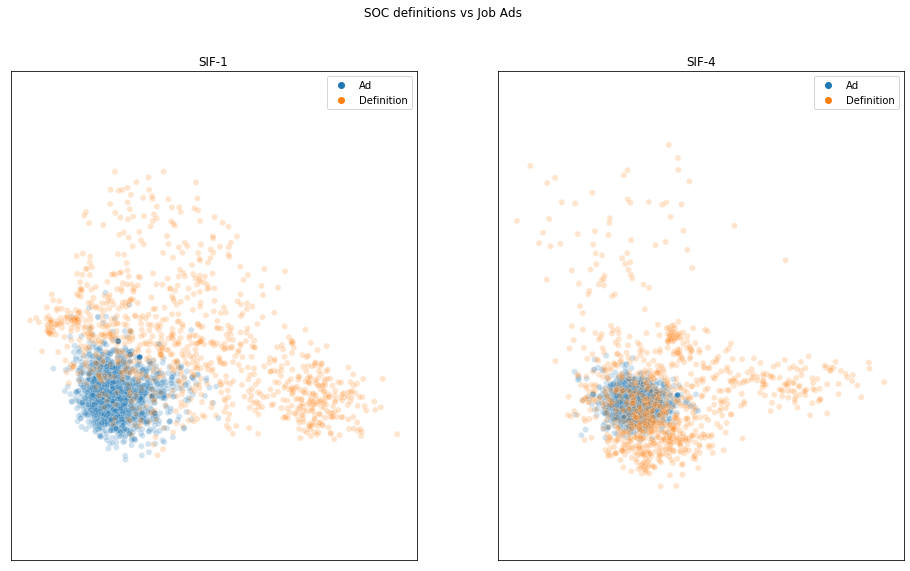

In [26]:
# visualize SIF vs. SIF-4 embedding
plot_pair(
    emb_subplot(*emb_plot_data(sif), 'SIF-1'),
    emb_subplot(*emb_plot_data(sif4), 'SIF-4'),
    'SOC definitions vs Job Ads'
)

That looks better, and substantially improved classification accuracy over SIF removing just the first common component; but the highest variance in the embedding is still the difference between BLS definitions and job ads. It also isn't enough of an improvement for SIF-4 to beat TF-IDF -> LSA.

Removing common components is a bit indirect. We could more explicitly target the difference between BLS definitions and job ads by using a logistic regression model as the component vector to remove.

In [27]:
# decorrelation functions
def _remove_components(X, unit_vectors):
    """Remove projection of X on unit component vectors"""
    if unit_vectors.shape[0] == 1:
        return X - X.dot(unit_vectors.T) * unit_vectors
    else:
        return X - X.dot(unit_vectors.T).dot(unit_vectors)


def logistic_decorr_transform_func(X, binary_label, transform_func=None, n_components=1):
    """
    Returns a function that transforms X in a way that minimizes correlation with a binary class label
    """
    if transform_func is not None:
        X = transform_func(X)

    end = n_components - 1
    for i in range(n_components):
        # fit logistic regression model to get component vector correlated with class label
        lr_model = lm.LogisticRegression(
            penalty='none', class_weight='balanced')
        lr_model.fit(X, binary_label)
        class_component = lr_model.coef_ / la.norm(lr_model.coef_)

        # save component vectors
        if i == 0:
            components = class_component
        else:
            components = np.vstack([components, class_component])

        # update embedding for next component
        X = _remove_components(X, class_component)

    # reduce embedding to selected affine subspace
    svd = dc.TruncatedSVD(n_components=X.shape[1] - n_components)
    svd.fit(X)

    def transform(data):
        return svd.transform(_remove_components(transform_func(data), components))

    return transform

In [28]:
# test 1-NN accuracy with repeat-decorrelated data
stages = []
scores = []
base_embed = []

for emb_func, emb in zip([tfidf_lsa, sif4], ['LSA', 'SIF-4']):
    for i in range(1, 11):
        decorr_test = logistic_decorr_transform_func(
            lemma_corpus, corpus_source, emb_func, n_components=i)

        _, score, _ = emb_score(decorr_test, X_test, y_test)

        stages.append(i)
        scores.append(score)
        base_embed.append(emb)

decorr_df = pd.DataFrame({
    'embedding': base_embed,
    'stage': stages,
    'score': scores
})

In [29]:
decorr_df.sort_values('score', ascending=False).head(20)

,embedding,stage,score
1,LSA,2,0.217515
2,LSA,3,0.216883
0,LSA,1,0.214986
3,LSA,4,0.214353
4,LSA,5,0.212773
5,LSA,6,0.212773
7,LSA,8,0.210560
8,LSA,9,0.210560
6,LSA,7,0.210560
9,LSA,10,0.208347


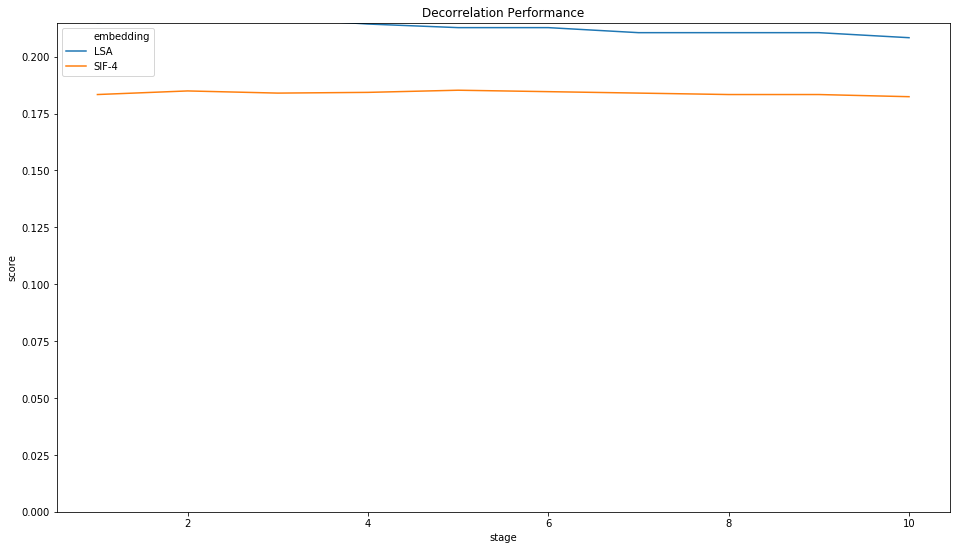

In [30]:
plt.figure(figsize=(16, 9))
sns.lineplot(x='stage', y='score', hue='embedding', data=decorr_df, ci=None)
plt.ylim(0, 0.215)
plt.title('Decorrelation Performance')
plt.show()

In [31]:
# fit decorrelated embeddings
lsa_decorr = logistic_decorr_transform_func(
            lemma_corpus, corpus_source, tfidf_lsa, n_components=1)
_, score, _ = emb_score(lsa_decorr, X_test, y_test)
save_emb_score('LSA Decorrelated', score, 'Vectorization')

sif_decorr = logistic_decorr_transform_func(
            lemma_corpus, corpus_source, sif4, n_components=2)
_, score, _ = emb_score(sif_decorr, X_test, y_test)
save_emb_score('SIF-4 Decorrelated', score, 'Vectorization')

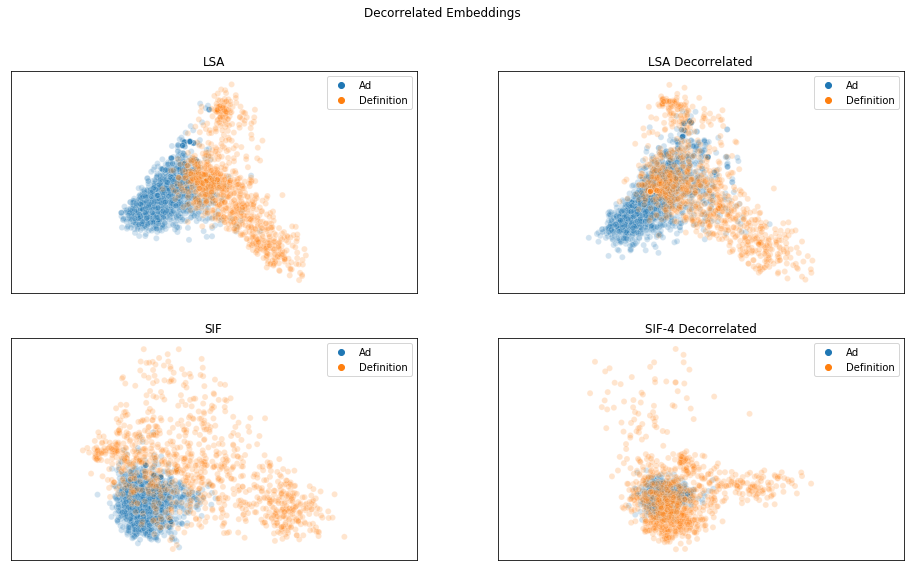

In [32]:
# visualize decorrelated embeddings
fig, ax = plt.subplots(2, 2, figsize=(16, 9))

emb_subplot(*emb_plot_data(tfidf_lsa), 'LSA')(ax[0][0])
emb_subplot(*emb_plot_data(lsa_decorr), 'LSA Decorrelated')(ax[0][1])
emb_subplot(*emb_plot_data(sif), 'SIF')(ax[1][0])
emb_subplot(*emb_plot_data(sif_decorr), 'SIF-4 Decorrelated')(ax[1][1])

plt.suptitle('Decorrelated Embeddings')
plt.show()

### Dimension Selection and Stacking

Mostly-unsupervised methods have been mediocre at placing SOC definitions and their corresponding job ads consistently close to each other in an embedding. Without labeled job ads, the embedding models don't have any task-specific information about which points should be close.

I try using L1-regularization on logistic regression to select a subset of dimensions that separates the two groups less. This strikes me as a minimal intervention. The embedding itself is still the real model being fit. I won't actually be using the logistic regression model for classification. Logistic regression does not enable me to force the model to use the official SOC definitions as class examplars like 1-NN does; and the embedding itself has additional downstream applications, such as identifying "emerging" occupations that are relatively far from, and thus not well characterized by, existing defined occupations.

While I'm at it, I also test an ensemble of the better-performing embeddings with qualitatively different constructions by concatenating them in inputs to logistic regression and 1-NN (stacking).

In [33]:
# labeled data is necessary for logistic regression
# train-test split labeled jobs
# k-fold cross-validation would be better, but some of the models take a long time to fit
dm_train, dm_test = ms.train_test_split(dm_jobs, test_size=0.2)

X_train = [*occupations['def_lemma'], *dm_train['desc_lemma']]
y_train = [*occupations['soc_detail'], *dm_train['soc_detail']]

X_test = dm_test['desc_lemma']
y_test = dm_test['soc_detail']

In [34]:
def keep_best(a, b):
    return a if a >= b else b

In [35]:
# L1 variable selection from LSA & SIF-4
def lsa_sif(X):
    return np.hstack([lsa_decorr(X), sif_decorr(X)])


# don't re-compute embedding in loop
X_train_trans = lsa_sif(X_train)
X_test_trans = lsa_sif(X_test)

best_score = 0
best_lr_score = 0

for p in [-3, -2, -1, 0, 1, 2, 3]:
    c = 2 ** p
    log_model = lm.LogisticRegression(penalty='l1', C=c, solver='saga',
                                      multi_class='multinomial', class_weight='balanced')
    log_model.fit(X_train_trans, y_train)

    dims = (np.max(log_model.coef_, axis=0) > 0)

    n_dims = dims.sum()
    if n_dims > 0:
        _, score, _ = emb_score(lambda x: lsa_sif(x)[:, dims], X_test, y_test)
        lr_score = log_model.score(X_test_trans, y_test)
        print(f'C={c}, dims: {n_dims}, score: {score:.6f}, logistic regression score: {lr_score:.6f}')
        
        best_score = keep_best(best_score, score)
        best_lr_score = keep_best(best_lr_score, lr_score)
        
        if n_dims >= 500:
            break


save_emb_score('LSA & SIF', best_score, 'Concat.')
save_emb_score('Logistic Regression', best_lr_score, 'Classifier')

C=0.25, dims: 7, score: 0.025276, logistic regression score: 0.000000
C=0.5, dims: 173, score: 0.189573, logistic regression score: 0.000000
C=1, dims: 403, score: 0.270142, logistic regression score: 0.072670
C=2, dims: 493, score: 0.285940, logistic regression score: 0.200632
C=4, dims: 483, score: 0.284360, logistic regression score: 0.368088
C=8, dims: 452, score: 0.285940, logistic regression score: 0.530806


In [36]:
# L1 variable selection from dim-wise scaled LSA and SIF-4
scaler = pp.MinMaxScaler().fit(X_train_trans)


def scaled_lsa_sif(x):
    return scaler.transform(lsa_sif(x))


# don't re-compute embedding in loop (or repeat lsa_sif)
X_train_trans = scaler.transform(X_train_trans)
X_test_trans = scaler.transform(X_test_trans)

best_score = 0
best_lr_score = 0

for p in [-3, -2, -1, 0, 1, 2, 3]:
    c = 2 ** p
    log_model = lm.LogisticRegression(penalty='l1', C=c, solver='saga',
                                      multi_class='multinomial', class_weight='balanced')
    log_model.fit(X_train_trans, y_train)

    dims = (np.max(log_model.coef_, axis=0) > 0)

    n_dims = dims.sum()
    if n_dims > 0:
        _, score, _ = emb_score(lambda x: scaled_lsa_sif(x)[:, dims], X_test, y_test)
        lr_score = log_model.score(X_test_trans, y_test)
        print(f'C={c}, dims: {n_dims}, score: {score:.6f}, logistic regression score: {lr_score:.6f}')
        
        best_score = keep_best(best_score, score)
        best_lr_score = keep_best(best_lr_score, lr_score)
        
        if n_dims >= 500:
            break

save_emb_score("Scaled LSA & SIF", best_score, 'Concat.')
save_emb_score("Scaled Logistic Regression", best_lr_score, 'Classifier')

C=0.5, dims: 253, score: 0.176935, logistic regression score: 0.004739
C=1, dims: 491, score: 0.206951, logistic regression score: 0.061611
C=2, dims: 497, score: 0.203791, logistic regression score: 0.189573
C=4, dims: 497, score: 0.203791, logistic regression score: 0.401264
C=8, dims: 497, score: 0.203791, logistic regression score: 0.548183


Selecting extremely few dimensions from LSA and SIF-4 harms performance. Otherwise, 1-NN classification performance appears to be mostly insensitive to dropping dimensions with L1 regularization. However, logistic regression performance consistently improves with increasing retained dimensions. There's adequate information in a subset of the dimensions to represent the important factors for identifying the occupation of a job ad, but the full set of dimensions is a more suitable representation for linear models.

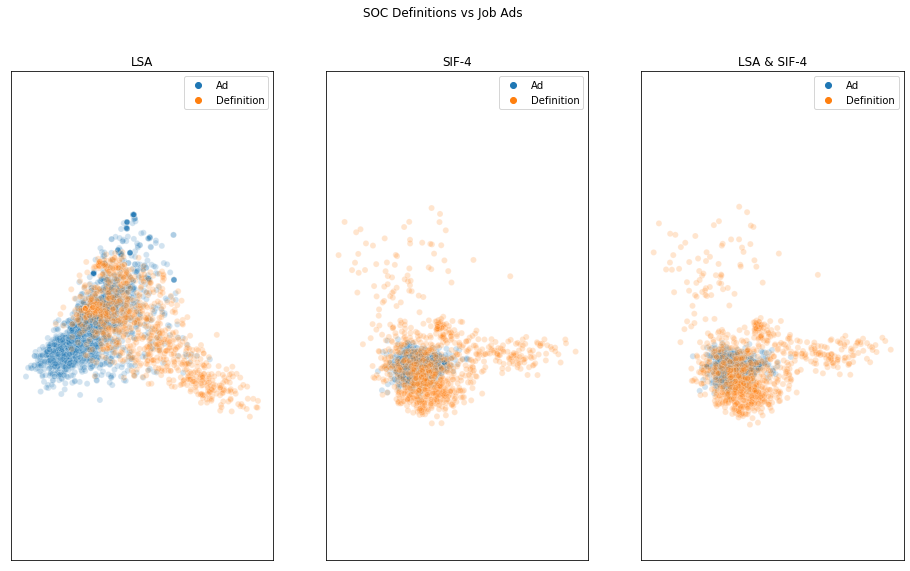

In [37]:
# visualize embedding improvement
fig, ax = plt.subplots(1, 3, figsize=(16, 9))

emb_subplot(*emb_plot_data(lsa_decorr), 'LSA')(ax[0])
emb_subplot(*emb_plot_data(sif_decorr), 'SIF-4')(ax[1])
emb_subplot(*emb_plot_data(lsa_sif), 'LSA & SIF-4')(ax[2])

plt.suptitle('SOC Definitions vs Job Ads')
plt.show()

The combination of LSA and SIF-4 performs better than either alone. Oddly, highest-variance principle components appear to be dominated by SIF-4, the weaker model. (Scaling might have changed this, but the unscaled combination performed better.)

### Metric Learning

The performances of the methods I'm trying are uniformly unsatisfying, so I'll try a more dramatically different approach to attempt to improve performance. The feature representation is only one factor of the embedding topology influencing the effectiveness of k-nearest-neighbor classification. The metric on the embedding is equally significant—it defines *which* neighbors are "nearest." I test several metric learning models next, using the pooled SOC definitions and labeled job ads as training data.

In [38]:
# metric 1: neighborhood components analysis
nca = metl.NCA().fit(lsa_sif(X_train), y_train)

_, score, _ = emb_score(lsa_sif, X_test, y_test, metric=nca.get_metric())
print(score)
save_emb_score('NCA', score, 'Metric')

0.3412322274881517


In [39]:
# metric 2: local fisher discriminant analysis
lfda = metl.LFDA(k=1).fit(lsa_sif(X_train), y_train)

_, score, _ = emb_score(lsa_sif, X_test, y_test, metric=lfda.get_metric())
print(score)
save_emb_score('LFDA', score, 'Metric')

0.12796208530805686


In [40]:
# metric 3: information theoretic metric learning
# itml doesn't accept text labels
soc_encode = pp.LabelEncoder().fit(occupations['soc_detail'])

itml = metl.ITML_Supervised(
    gamma=20,
    convergence_threshold=1e-6,
    num_constraints=len(occupations) * 3)
itml.fit(lsa_sif(X_train), soc_encode.transform(y_train))

_, score, _ = emb_score(lsa_sif, X_test, y_test, metric=itml.get_metric())
print(score)
save_emb_score('ITML', score, 'Metric')

0.42338072669826227


In [41]:
# metric 4: relevant components analysis
rca = metl.RCA_Supervised().fit(lsa_sif(X_train), soc_encode.transform(y_train))

_, score, _ = emb_score(lsa_sif, X_test, y_test, metric=rca.get_metric())
print(score)
save_emb_score('RCA', score, 'Metric')

0.001579778830963665


In [42]:
# wrap best metric as an embedding to euclidean metric space
def metric_emb(X):
    return itml.transform(lsa_sif(X))

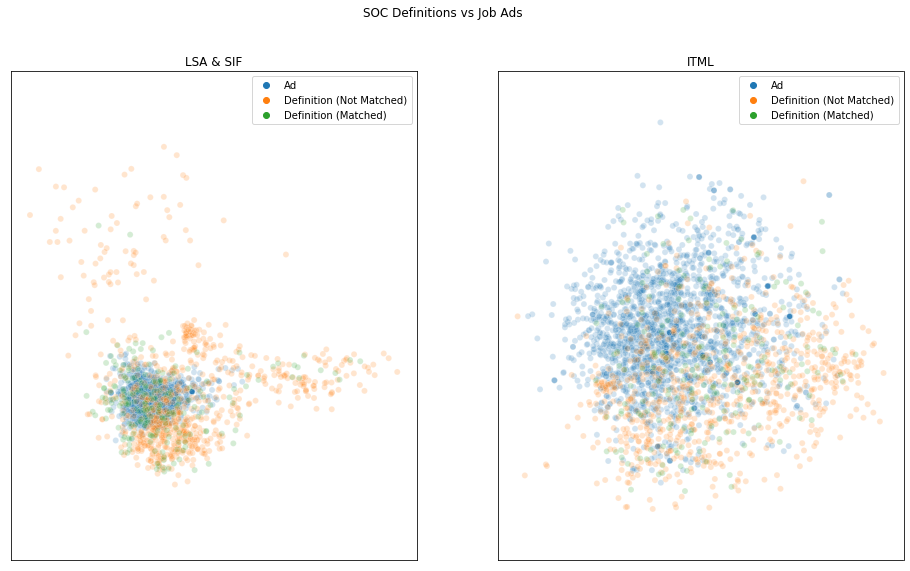

In [43]:
# visualize embedding improvement
split_soc_plot_data = fn.partial(emb_plot_data, split_soc_defs=True)

plot_pair(
    emb_subplot(*split_soc_plot_data(lsa_sif),
                'LSA & SIF'),
    emb_subplot(*split_soc_plot_data(metric_emb),
                'ITML'),
    'SOC Definitions vs Job Ads'
)

Information-theoretic metric learning (ITML) significantly improves 1-NN classification accuracy. ITML shifts the data so that job ads occupy a region more similar to SOC definitions. The SOC definitions in the LSA & SIF embedding have a much more dispersed distribution than job ads. Any distinctive words in the definitions must be less frequent in job ads, which dominate the combined corpus. This increases the inverse (document) frequency of those words, pushing definitions to more extreme positions. ITML creates a more compact distribution, but it especially pulls the SOC definitions with direct title matches to job ads closer to the job ads. ITML leaves some of the unmatched definitions further away. Unmatched definitions only have weaker proxy relationships to job ads though similar matched definitions.

Though ITML improves 1-NN classification accuracy, I can only measure this accuracy on matched jobs, and ITML can only do so much without matching job ads for more occupations.

### Boosted Error Correcting Output Codes

Error-correcting output codes (ECOC) are an ensemble method for constructing multi-class classifiers out of a series of binary classifiers. Many variations on ECOC either implicitly or explicitly include bagging or boosting in the assignment of code sequences to target classes.

I think the combination of ECOC and boosting is a promising approach not only for assigning SOC codes to job ads, but also as an embedding that is both compact and coerces the distributions of BLS definitions and job ads into the same region.

In [44]:
# ECOCBoostClassifier class
import scipy.spatial.distance as dist
import sklearn.base as bs
import sklearn.utils as utl


def _boost_split(confusion_matrix):
    """lists of class indices that split classes to improve discrimination in next boost round"""
    n = len(confusion_matrix)
    cpm = _confusion_pair_matrix(confusion_matrix)
    cpm_rem = np.copy(cpm)
    a = []
    b = []
    a_size = 0
    b_size = 0
    class_size = np.sum(confusion_matrix, axis=1)
    zero_size = np.where(class_size < 1)[0]

    # separate pairs that are most confused
    max_val = np.inf

    while max_val > 0:
        # select most-confused pair
        row_maxs = np.max(cpm, axis=1)
        i = np.argmax(row_maxs)
        j = np.argmax(cpm[i])
        max_val = cpm[i, j]
        if max_val == 0:
            break

        # split pair into separate labels
        if a_size == 0:
            a.append(i)
            a_size += class_size[i]
            b.append(j)
            b_size += class_size[j]
        else:
            # minimize confusion with already-split pairs
            ia_conf = _total_confusion(confusion_matrix, i, a)
            ib_conf = _total_confusion(confusion_matrix, i, b)
            ja_conf = _total_confusion(confusion_matrix, j, a)
            jb_conf = _total_confusion(confusion_matrix, j, b)

            ia_jb_conf = ia_conf + jb_conf
            ib_ja_conf = ib_conf + ja_conf
            ab_diff = a_size - b_size
            ij_diff = class_size[i] - class_size[j]

            if ia_jb_conf > ib_ja_conf or (ia_jb_conf == ib_ja_conf and ab_diff * ij_diff < 0):
                a.append(i)
                a_size += class_size[i]
                b.append(j)
                b_size += class_size[j]
            else:
                b.append(i)
                b_size += class_size[i]
                a.append(j)
                a_size += class_size[j]

        # prevent selecting the same classes again
        cpm[i] = 0
        cpm[j] = 0
        cpm[:, i] = 0
        cpm[:, j] = 0

    # split remaining classes confused only with already-split classes
    cpm_rem[a] = 0
    cpm_rem[b] = 0
    row_maxs = np.max(cpm_rem, axis=1)
    confused_rows = np.argsort(-1 * row_maxs)

    for i in confused_rows:
        if row_maxs[i] < 1:
            break

        # minimize confusion with already-split pairs
        a_conf = _total_confusion(confusion_matrix, i, a)
        b_conf = _total_confusion(confusion_matrix, i, b)
        if a_conf > b_conf or (a_conf == b_conf and a_size <= b_size):
            a.append(i)
            a_size += class_size[i]
        else:
            b.append(i)
            b_size += class_size[i]

    # split remaining classes with no confusion and non-zero size
    class_size[a] = 0
    class_size[b] = 0
    sized_rows = np.where(class_size > 0)[0]
    np.random.shuffle(sized_rows)

    for i in sized_rows:
        if class_size[i] < 1:
            break

        # balance the sample sizes in each label
        if a_size <= b_size:
            a.append(i)
            a_size += class_size[i]
        else:
            b.append(i)
            b_size += class_size[i]

    # split classes with no samples
    np.random.shuffle(zero_size)
    for i in zero_size:
        if i not in a and i not in b:
            if len(a) >= len(b):
                a.append(i)
            else:
                b.append(i)

    return a, b


def _confusion_pair_matrix(cm):
    """upper-triangular confusion matrix combining both confusions for each pair"""
    n = len(cm)
    cpm = np.copy(cm)
    for i, j in itr.product(range(n), range(n)):
        if i < j:
            cpm[i, j] += cm[j, i]  # combine confusion pair
        else:
            cpm[i, j] = 0
    return cpm


def _total_confusion(cm, a, b):
    """sum of confusion matrix cells matched by a and b"""
    return np.sum(cm[a, b]) + np.sum(cm[b, a])


def iceil(x):
    return int(np.ceil(x))


def ifloor(x):
    return int(np.floor(x))


def _min_binary_code(n):
    """minimal binary code for n classes"""
    code = []
    for p in range(n_bits(n)):
        m = 2 ** (p + 1)
        code.append([ifloor(i * m / n + p) % 2 for i in range(n)])
    return np.array(code).T


def n_bits(n):
    """number of bits necessary in a binary code for n keys"""
    return iceil(np.log2(n))


class ECOCBoostClassifier(bs.BaseEstimator, bs.ClassifierMixin):
    def __init__(self, binary_classifier=None, n_estimators=None):
        if binary_classifier is None:
            self.binary_classifier = lm.LogisticRegression(class_weight='balanced')
        else:
            self.binary_classifier = binary_classifier

        self.n_estimators = n_estimators

    def _class(self, code, subset_indices=None):
        """predicted class for a single code"""
        min_dist = np.inf
        class_i = None
        if subset_indices is None:
            class_codes = self.class_codes_
        else:
            class_codes = self.class_codes_[:, subset_indices]
        for i, c in enumerate(class_codes):
            d = dist.hamming(code, c)
            if d < min_dist:
                min_dist = d
                class_i = i
                if min_dist == 0:
                    break
        return self.classes_[class_i]

    def _fit_min_code(self, X, y):
        """fits estimators for an initial minimum-necessary code"""
        n_classes = len(self.classes_)
        for split in _min_binary_code(n_classes).T:
            self._fit_new_estimator(X, y, split)
            
        return None

    def _fit_new_estimator(self, X, y, code_split):
        """new instance of binary_classifier fit to a given code split"""
        y_indices = [self.class_index_[label] for label in y]
        y_label = code_split[y_indices]
        est = bs.clone(self.binary_classifier)
        est.fit(X, y_label)
        
        new_code = code_split.reshape(-1, 1)
        if self.class_codes_ is None:
            self.class_codes_ = new_code
        else:
            self.class_codes_ = np.hstack([self.class_codes_, new_code])
        self.estimators_.append(est)
        return est

    def fit(self, X, y):
        X, y = utl.check_X_y(X, y, dtype=None)  # validate input
        self.classes_ = utl.multiclass.unique_labels(y)
        self.class_index_ = {c: i for i, c in enumerate(self.classes_)}

        # set n_estimators
        min_estimators = n_bits(len(self.classes_))
        if self.n_estimators is None:
            self.n_estimators = min_estimators
        else:
            self.n_estimators = max(min_estimators, self.n_estimators)

        self.class_codes_ = None
        self.estimators_ = []
        self._fit_min_code(X, y)

        # fit remaining estimators by sequential boosting
        n_classes = len(self.classes_)
        while len(self.estimators_) < self.n_estimators:
            y_pred = self.predict(X)
            cm = met.confusion_matrix(y, y_pred, labels=self.classes_)
            
            # split classes most confused with each other into separate labels
            a, b = _boost_split(cm)
            a_balance = np.mean(self.class_codes_[a])
            b_balance = np.mean(self.class_codes_[b])
            if a_balance >= b_balance:  # nudge codes toward even mix of 0 and 1
                new_split = [0 if i in a else 1 for i in range(n_classes)]
            else:
                new_split = [1 if i in a else 0 for i in range(n_classes)]
            
            self._fit_new_estimator(X, y, np.array(new_split))

        return self

    def fit_transform(self, X, y):
        return self.fit(X, y).transform(X)

    def predict(self, X, subset_indices=None):
        return [self._class(c, subset_indices) for c in self.transform_code(X, subset_indices)]

    def transform(self, X, subset_indices=None):
        """probability vectors for X"""
        utl.validation.check_is_fitted(self)
        if subset_indices is None:
            estimators = self.estimators_
        else:
            estimators = np.array(self.estimators_)[subset_indices]
        return np.array([est.predict_proba(X).T[1] for est in estimators]).T

    def transform_code(self, X, subset_indices=None):
        """binary code values for X"""
        utl.validation.check_is_fitted(self)
        if subset_indices is None:
            estimators = self.estimators_
        else:
            estimators = np.array(self.estimators_)[subset_indices]
        return np.array([est.predict(X) for est in estimators]).T

In [45]:
# LSA -> ECOCBoostClassifier
# n_estimators = n_bits(occupations['soc_detail'].nunique())
n_estimators = n_bits(occupations['soc_detail'].nunique()) * 10
lsa_ecoc = ECOCBoostClassifier(n_estimators=n_estimators)
lsa_ecoc.fit(lsa_decorr(X_train), y_train)

# accuracy of ECOC classifier
y_pred = lsa_ecoc.predict(lsa_decorr(X_test))
score = met.accuracy_score(y_test, y_pred)
print(score)
save_emb_score('LSA ECOC Classifier', score, 'Classifier')

0.6034755134281201


In [46]:
# LSA -> ECOC accuracy on SOC definitions
y_pred = lsa_ecoc.predict(lsa_decorr(bls_occupations['def_lemma']))
score = met.accuracy_score(y_bls, y_pred)
print(score)

0.0330188679245283


In [47]:
# accuracy of 1-NN on LSA -> ECOC embedding
_, score, _ = emb_score(lambda x: lsa_ecoc.transform(lsa_decorr(x)),
                        X_test, y_test)
print(score)
save_emb_score('LSA ECOC', score, 'Dimension Reduction')

0.16587677725118483


In [48]:
# LSA & SIF-4 -> ITML -> ECOCBoostClassifier
metric_ecoc = ECOCBoostClassifier(n_estimators=n_estimators)
metric_ecoc.fit(metric_emb(X_train), y_train)

y_pred = metric_ecoc.predict(metric_emb(X_test))
score = met.accuracy_score(y_test, y_pred)
print(score)
save_emb_score('ITML ECOC Classifier', score, 'Classifier')

0.6334913112164297


In [49]:
# LSA & SIF-4 -> ITML -> ECOC accuracy on SOC definitions
y_pred = metric_ecoc.predict(metric_emb(bls_occupations['def_lemma']))
score = met.accuracy_score(y_bls, y_pred)
print(score)

0.060141509433962265


In [50]:
# accuracy of 1-NN on LSA & SIF -> ITML -> ECOC embedding
_, score, _ = emb_score(lambda x: metric_ecoc.transform(metric_emb(x)),
                        X_test, y_test)
print(score)
save_emb_score('ITML ECOC', score, 'Dimension Reduction')

0.320695102685624


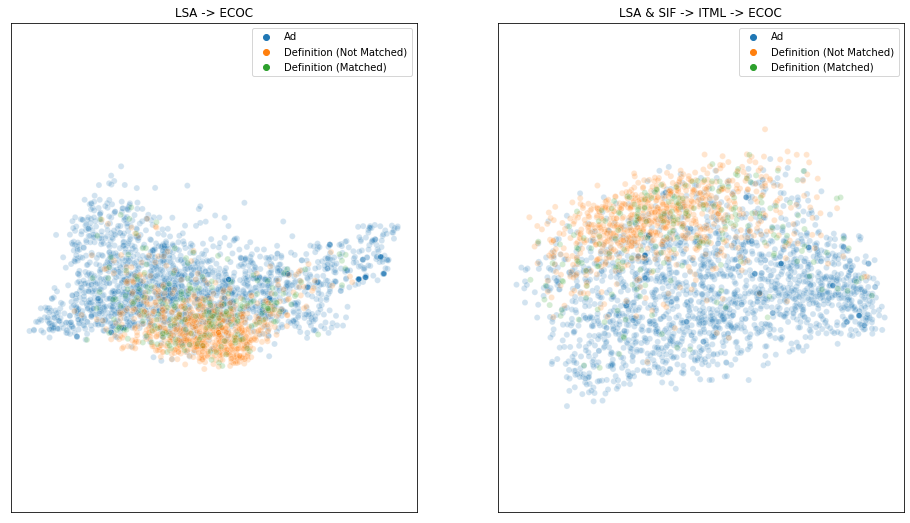

In [51]:
# visualize ECOC embeddings
plot_pair(
    emb_subplot(*split_soc_plot_data(lambda x: lsa_ecoc.transform(lsa_decorr(x))),
                'LSA -> ECOC'),
    emb_subplot(*split_soc_plot_data(lambda x: metric_ecoc.transform(metric_emb(x))),
                'LSA & SIF -> ITML -> ECOC')
)

ECOC constructs a (hyper)cube where each vertex represents a target class. Using logistic regression as the base estimator, fitting ECOC has the effect of creating an embedding where data are pulled toward their appropriate vertex. ECOC as a classifier is equivalent to 1-NN on this embedding using the target vertices as the reference points. I hoped this would create an embedding where 1-NN with the SOC definitions as the reference points would be a better classifier, but I was not successful. The variation on ECOC I constructed focuses on overall classification accuracy, but does not make any special effort to diminish the distinction between definitions and job ads. The plots of the ECOC embeddings show this as the job ads distributed in most of the cube's vertices, and definitions distributed in a smaller subset of vertices. This is reflected quantitatively in how the ECOC classifiers perform poorly on the SOC definitions.

Since the variation on ECOC I constructed is a boosting ensemble, I can retroactively test the accuracy of the model with fewer estimators than were trained in order to evaluate the accuracy/complexity tradeoff at different model sizes.

In [52]:
def ecoc_sub_accuracy(ecoc_model, x_transform_func, n):
    y_pred = ecoc_model.predict(x_transform_func(X_test), np.arange(n))
    return met.accuracy_score(y_test, y_pred)

In [53]:
# test accuracy for different ensemble sizes
min_est = n_bits(occupations['soc_detail'].nunique())
max_est = n_estimators

n_set = np.linspace(min_est, max_est, num=10).astype(int)

acc_df = pd.DataFrame({
    'estimators': n_set,
    'LSA': [ecoc_sub_accuracy(lsa_ecoc, lsa_decorr, i) for i in n_set],
    'ITML': [ecoc_sub_accuracy(metric_ecoc, metric_emb, i) for i in n_set]
})
acc_df = pd.melt(acc_df, id_vars='estimators', value_name='accuracy')

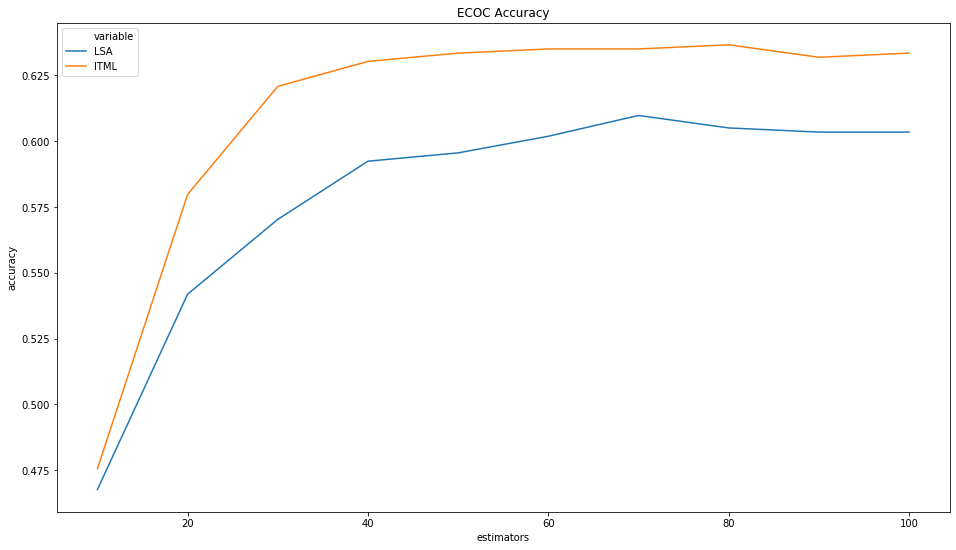

In [54]:
plt.figure(figsize=(16, 9))
sns.lineplot(x='estimators', y='accuracy', hue='variable', data=acc_df, ci=None)
plt.title('ECOC Accuracy')
plt.show()

In [55]:
acc_df.sort_values('accuracy', ascending=False).head(1)

,estimators,variable,accuracy
17,80,ITML,0.636651


## Performance Summary

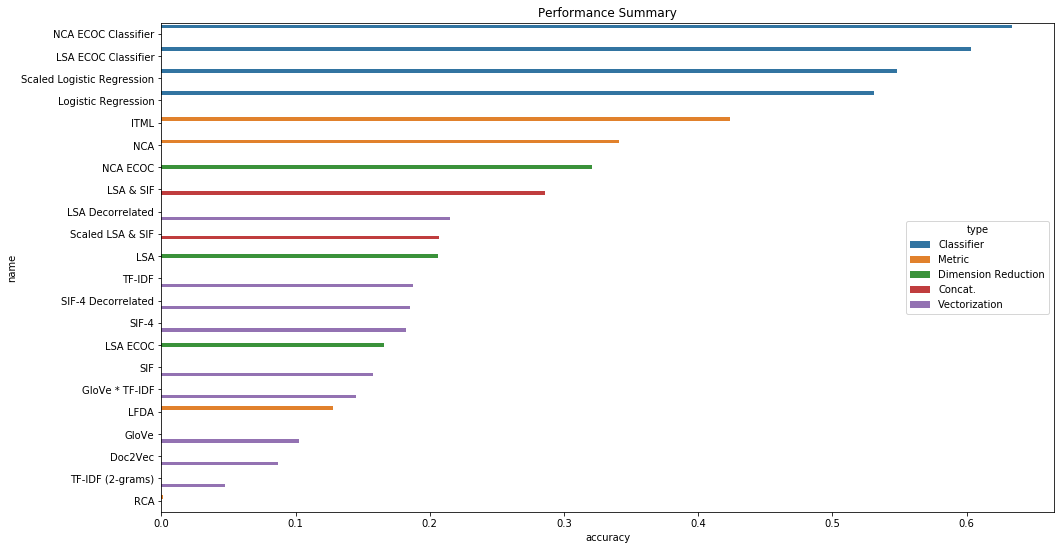

In [56]:
# plot summary performance comparison
scores_df = emb_score_dataframe().sort_values('accuracy', ascending=False)

plt.figure(figsize=(16, 9))
sns.barplot(x='accuracy', y='name', hue='type', data=scores_df, ci=None)
plt.title('Performance Summary')
plt.show()

## The Point: Labor Market Surveillance (Counting Jobs)

Given the mediocre accuracy I've been able to achieve so far, this may be premature. But it's still worth demonstrating what this is for.

In [57]:
def soc_details(job_lemmas):
    """estimated detail-level SOC codes for each lemmatized job description"""
    return metric_ecoc.predict(metric_emb(job_lemmas))

In [58]:
# classify all jobs
job_soc = soc_details(jobs['desc_lemma'])

In [59]:
# count job ads for each occupation
socs, counts = np.unique(job_soc, return_counts=True)

occupation_counts = pd.DataFrame({
    'soc_detail': socs,
    'title': [title_from_soc(s) for s in socs],
    'count': counts
})

print(f'{len(socs)} occupations were identified in the job ads')

420 occupations were identified in the job ads


In [60]:
# what are the most-advertized jobs?
top_socs = occupation_counts.sort_values('count', ascending=False)
top_socs.head(20)

,soc_detail,title,count
1,11-1021,General and Operations Managers,5158
5,11-2022,Sales Managers,4949
49,13-1161,Market Research Analysts and Marketing Special...,2580
72,15-1252,Software Developers,2112
44,13-1111,Management Analysts,2074
267,41-1011,First-Line Supervisors of Retail Sales Workers,1554
51,13-2011,Accountants and Auditors,1395
287,43-3031,"Bookkeeping, Accounting, and Auditing Clerks",761
59,13-2072,Loan Officers,758
29,11-9141,"Property, Real Estate, and Community Associati...",657


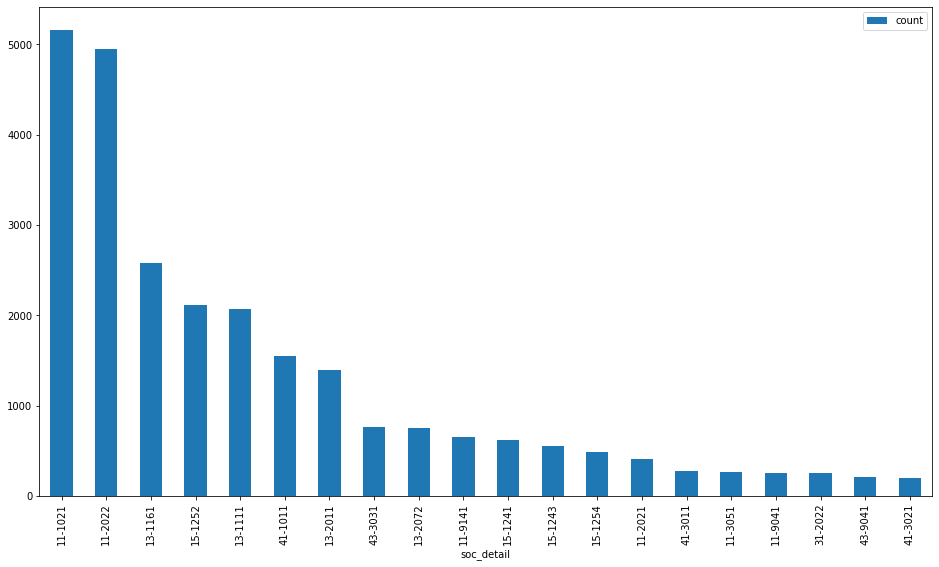

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
top_socs.iloc[:20].plot.bar(x='soc_detail', y='count', ax=ax)
plt.show()

## Conclusion

I set out to build a model to automatically label job ads with SOC codes. My preliminary efforts achieved **63.7%** accuracy. This is a substantial improvement over the **0.1%** that might be achieved by random guessing. This is also better than the **39.3%** accuracy [demonstrated by Nicholas Thiebaut](https://data4thought.com/fewshot_learning_nlp.html) by fitting a *more complicated* model with *more samples* (but less detailed data: titles only vs. descriptions/ads).

I hoped to perform classification on some suitable embedding by a 1-NN classifier using the BLS and O\*NET information for each occupation as the reference points. Sticking to the official BLS definitions would lend some validity to the model, and the embedding would have been valuable for other purposes such as identifying emerging occupations not well-described by the current SOC system.

Unsupervised text embedding methods were not particularly effective. BLS SOC definitions and job ads both use idiosyncratic language, and that is a likely dominant factor leading to text embeddings where SOC definitions are closer to each other than to their matching job ads. Removing linear components correlated with document type slightly improved performance.

The best unsupervised (in the sense of not using occupation labels) embedding was ultimately the concatenation of LSA & SIF-4, both decorrelated with respect to document type, which achieved an accuracy of 28.6% in 1-NN classification.

Closing the gap between SOC definitions and job ads apparently requires fitting with labeled job ads. I labeled some job ads using direct title matches provided by the BLS. I used this labeled data to construct and compare several methods of producing an embedding that might serve the project goals.

- Feature selection using L1-regularized logistic regression found that dropping features from the unsupervised embedding mostly harms performance. The resulting logistic regression classifier improved accuracy to **54.8%**, but that model has fewer downstream uses.
- By testing several metric learning models, I constructed an embedding with **63.3%** accuracy in 1-NN classification with neighborhood components analysis.
- I constructed a boosted error-correcting output code (ECOC) model with **63.7%** accuracy. This is particularly remarkable considering that it achieves this *using only 100 binary estimators to predict 848 classes*. However, the embedding induced by ECOC only managed **32.1%** accuracy in 1-NN classification.

All methods were only marginally effective at pushing SOC definitions and job ads closer together. Only 167 occupations out of 848 (20%) include matching labeled job ads in my data set. The top priority for continuing to improve this model is gathering more data, and more diverse data, in particular. Indeed.com doesn't list jobs in many blue-collar occupations, and many occupations are not typically recruited via job ads at all (e.g., chief executives).

My boosted ECOC model improves on the accuracy of the similar work I was able to find. However, plots showed that it is only modestly effective at dispersing SOC definitions throughout the induced embedding. I intend to create a new variation that places more emphasis on handling "examplar" or "anchor" points like these. A more traditional boosting method that focuses on training samples, as opposed to target classes, might also help with this.

My best classifier included a chain of TF-IDF, LSA, GloVe, SIF, NCA, and boosted ECOC. Many of these steps amount to a chain of linear transformations, and it should be possible to consolidate them. It might be possible to construct a globally simpler model that achieves similar (or better) accuracy using a simpler embedding (e.g., just LSA on TF-IDF) feeding directly into an ensemble with more base classifiers.